In [ ]:
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
#from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:
# Check the torch version
print('torch version: %s' %torch.__version__)


torch version: 2.0.0+cu118


In [ ]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
list_figs = os.listdir('./')
print(list_figs)


['.config', 'img.tif', 'Sample 6-50 X.tif', 'Sample 7-50 X.tif', 'sample_data']


ENTER THE FILE NAME: img.tif


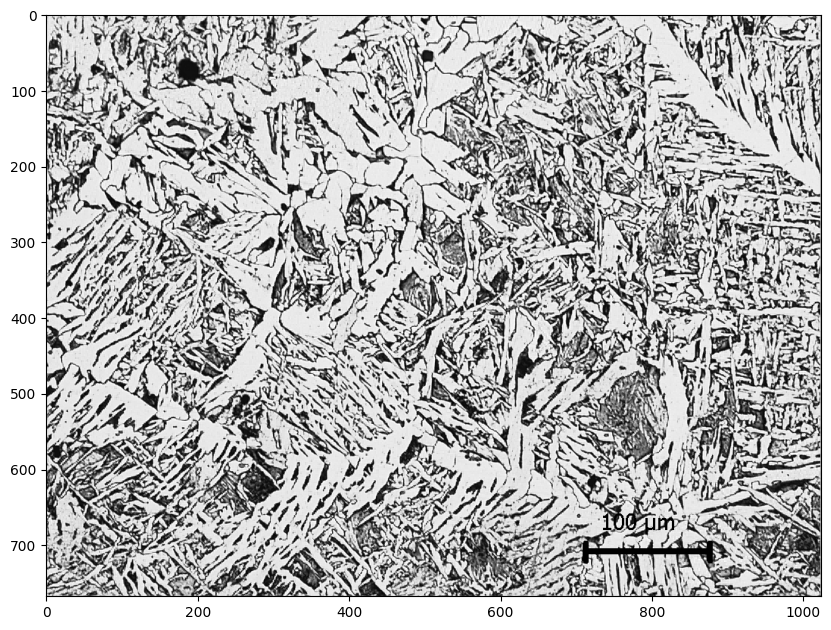

In [ ]:
# Load and show the input image
filename = input('ENTER THE FILE NAME: ')
img = cv2.imread('./' + filename)
plt.figure(figsize = (10,10))
plt.imshow(img)

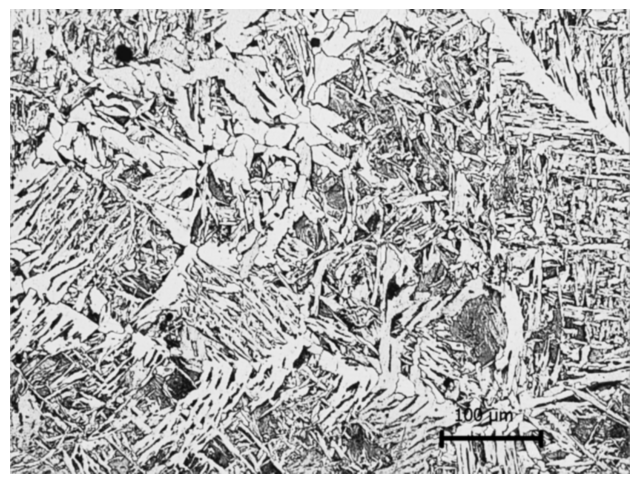

In [ ]:
# Gaussian_filter-more fine way of blurring
im = cv2.GaussianBlur(img, (5,5),0)
fig=plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(im,cmap='gray')
# im=img

In [ ]:
# Variables
nChannel = 100 # default=100
maxIter = 2000 # default=1000
minLabels = 4  # default=3, determines the minimum number of labels for cnn training
learn_rate = 0.1 # default=0.1
nConv = 4 # default=2
num_superpixels = 10000 # default=10000, a lower number may yield a bad result
compactness_value = 10 # default = 100, optimal value is around 10

In [ ]:
# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        # size of the output: [(W−K+2P)/S]+1 in case of width
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()

        # Convolutional filters
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )

        # Linear classifier
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )

        # Batch normalization
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = x.to(device)
        x = self.conv1(x)
        x = F.leaky_relu( x )
        x = self.bn1(x)
        for i in range(nConv-1):
            x = self.conv2[i](x)
            x = F.leaky_relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [ ]:
# Change the order of dimension: HEIGHT, WIDTH, CHANNEL --> CHANNEL, HEIGHT, WIDTH
im_trans = np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.])

# Change the type of data: numpy to torch
data = torch.from_numpy(im_trans)
data = Variable(data)
# data = data.cuda()

Text(0.5, 1.0, 'superpixel boundaries')

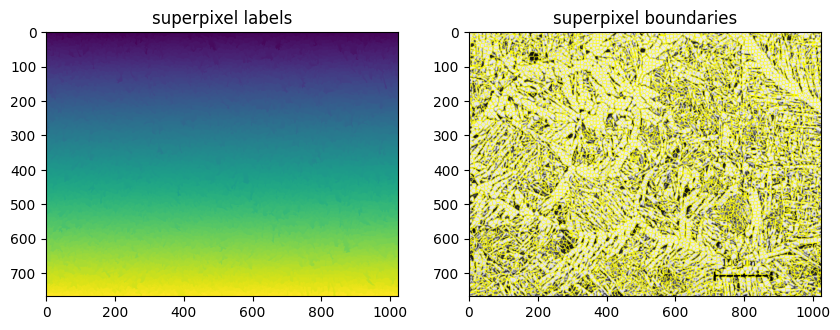

In [ ]:
# Superpixels labels
labels = segmentation.slic(im, compactness=compactness_value, n_segments=num_superpixels)

# Superpixels boundaries
boundaries = segmentation.mark_boundaries(im, labels)

# Plot labels and boundaries
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.imshow(labels)
plt.title('superpixel labels')
fig.add_subplot(1,2,2)
plt.imshow(boundaries)
plt.title('superpixel boundaries')

In [ ]:
# Reshape labels into 1D
labels = labels.reshape(im.shape[0]*im.shape[1])

# Extract unique labels
u_labels = np.unique(labels)

# l stands for location
'''
l_inds CONSISTS OF N SUPERPIXELS AS NUMPY ARRAYS.
EACH ELEMENT CONTAINS LOCATIONS OF EACH SUPERPIXEL.
'''

l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [ ]:
# Initialize model
model = MyNet( data.size(1) )
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)

# Begin training
label_colours = np.random.randint(255,size=(100,3))
for batch_idx in range(maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if 0:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        cv2.imshow( "output", im_target_rgb )
        cv2.waitKey(10)

    # Superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', maxIter, ':', nLabels, loss.item())

    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
        break

0 / 2000 : 100 4.50908899307251
1 / 2000 : 100 4.219955921173096
2 / 2000 : 100 4.080280780792236
3 / 2000 : 100 3.9345569610595703
4 / 2000 : 95 3.8591158390045166
5 / 2000 : 88 3.7485454082489014
6 / 2000 : 79 3.6068038940429688
7 / 2000 : 68 3.4175474643707275
8 / 2000 : 58 3.2102012634277344
9 / 2000 : 50 3.003072500228882
10 / 2000 : 39 2.804041862487793
11 / 2000 : 29 2.5858728885650635
12 / 2000 : 19 2.3578643798828125
13 / 2000 : 14 2.132192611694336
14 / 2000 : 13 1.927286148071289
15 / 2000 : 10 1.7206993103027344
16 / 2000 : 9 1.5282117128372192
17 / 2000 : 10 1.3697525262832642
18 / 2000 : 8 1.2118184566497803
19 / 2000 : 8 1.0808779001235962
20 / 2000 : 8 0.9692863821983337
21 / 2000 : 6 0.8557552695274353
22 / 2000 : 5 0.7759807705879211
23 / 2000 : 4 0.7124004364013672
nLabels 4 reached minLabels 4 .


In [ ]:
# DESIGNATE RANDOM COLORS TO CLASSES
output = model( data )[ 0 ]
output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
ignore, target = torch.max( output, 1 )
im_target = target.data.cpu().numpy()


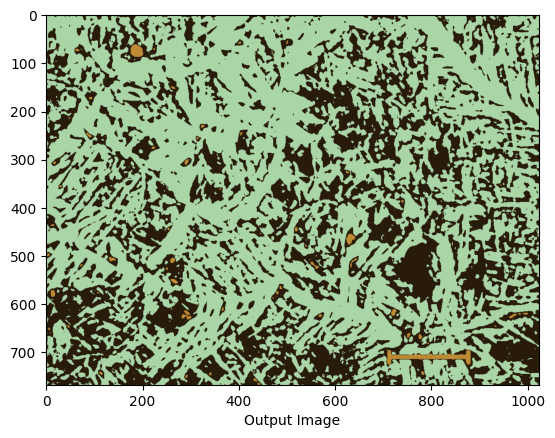

In [ ]:
label_colours = np.random.randint(255,size=(100,3))

output_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
# plt.subplot(1, 2, 1)
# plt.xlabel("Input Image")
# plt.imshow(img)
# plt.subplot(1, 2, 2)
plt.xlabel("Output Image")
plt.imshow(output_rgb.reshape(img.shape))

# cv2.imwrite('./samples/'+'output_' + filename, output_rgb.reshape(im.shape) )